In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("complete_data.csv",index_col=[0])

In [4]:
df.head()

,lessonId,views,student_view_count,questions_count,numberOfCorrectAnswers,numberOfWrongAnswers,numberOfSkippedQuestions,score,userId,count_new,...,subject_Further Mathematics,subject_Home Economics,subject_Literature in English,subject_Mathematics,subject_Module 1 HTML for Beginners,subject_Module 2 CSS for Beginners,subject_Module 3 Javascript for Beginners,subject_Physics,subject_Social Studies,subject_Yoruba
0,611a4e13aaba0c0016e02a21,73.0,80.0,0.0,0.0,0.0,0.0,0.0,645c07901889210014549ee3,5,...,0,0,0,0,0,0,0,0,0,1
1,611a53a5aaba0c0016e02a8a,3.0,6.0,0.0,0.0,0.0,0.0,0.0,645be4461889210014549a4c,4,...,0,0,0,0,0,0,0,0,0,1
2,611a520caaba0c0016e02a67,6.0,7.0,0.0,0.0,0.0,0.0,0.0,645be4461889210014549a4c,5,...,0,0,0,0,0,0,0,0,0,1
3,611a4e74aaba0c0016e02a25,23.0,27.0,0.0,0.0,0.0,0.0,0.0,645be4461889210014549a4c,10,...,0,0,0,0,0,0,0,0,0,1
4,611a4e13aaba0c0016e02a21,73.0,80.0,0.0,0.0,0.0,0.0,0.0,645a3d0c695c590014222ef9,9,...,0,0,0,0,0,0,0,0,0,1


In [175]:
df['lessonId'].nunique()

1149

In [6]:
data = df[['userId','lessonId','views']]

In [7]:
data

,userId,lessonId,views
0,645c07901889210014549ee3,611a4e13aaba0c0016e02a21,73.0
1,645be4461889210014549a4c,611a53a5aaba0c0016e02a8a,3.0
2,645be4461889210014549a4c,611a520caaba0c0016e02a67,6.0
3,645be4461889210014549a4c,611a4e74aaba0c0016e02a25,23.0
4,645a3d0c695c590014222ef9,611a4e13aaba0c0016e02a21,73.0
...,...,...,...
4895,60941a8a1523405f74ddb94e,6012bdcecfe09249249f7e9e,23.0
4896,60941a8a1523405f74ddb94e,6012bdcecfe09249249f7e9c,62.0
4897,60941a8a1523405f74ddb94e,6012bdcecfe09249249f7e9c,62.0
4898,60941a8a1523405f74ddb94e,6012bdcecfe09249249f7e9e,23.0


In [9]:
from sklearn.model_selection import train_test_split

In [10]:
train_data_df,validation_data_df = train_test_split(data,test_size=0.2)

In [18]:
class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_lessons, emb_size=10):
        super(MatrixFactorization, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.lesson_emb = nn.Embedding(num_lessons, emb_size)
        self.user_emb.weight.data.uniform_(0, 0.05)
        self.lesson_emb.weight.data.uniform_(0, 0.05)
        
    def forward(self, u, v):
        u = self.user_emb(u)
        v = self.lesson_emb(v)
        return (u*v).sum(1)  

In [13]:
num_users = len(train_data_df.userId)
num_lessons = len(train_data_df)
print(num_users, num_lessons) 

3920 3920


In [26]:
train_data_df= train_data_df.reset_index(drop=True)
validation_data_df = validation_data_df.reset_index(drop=True)

In [44]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [45]:
scaler = MinMaxScaler((1,5))
train_data_df['views']=scaler.fit_transform(np.array(train_data_df['views']).reshape(-1,1)).ravel()
validation_data_df['views']=scaler.fit_transform(np.array(validation_data_df['views']).reshape(-1,1)).ravel()

In [34]:
from sklearn.preprocessing import LabelEncoder

In [35]:
le= LabelEncoder()
train_data_df['userId']= le.fit_transform(train_data_df['userId'])
train_data_df['lessonId']= le.fit_transform(train_data_df['lessonId'])

In [36]:
validation_data_df['userId']= le.fit_transform(validation_data_df['userId'])
validation_data_df['lessonId']= le.fit_transform(validation_data_df['lessonId'])

In [19]:
model = MatrixFactorization(num_users, num_lessons)
model

MatrixFactorization(
  (user_emb): Embedding(3920, 10)
  (lesson_emb): Embedding(3920, 10)
)

In [23]:
def train_epocs(model, epochs=10, lr=0.01, wd=0.0, unsqueeze=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    model.train()
    for i in range(epochs):
        users = torch.LongTensor(train_data_df.userId.values) # .cuda()
        lessons = torch.LongTensor(train_data_df.lessonId.values) #.cuda()
        views = torch.FloatTensor(train_data_df.views.values) #.cuda()
        if unsqueeze:
            lessons = lessons.unsqueeze(1)
        y_hat = model(users, lessons)
        loss = F.mse_loss(y_hat, views)
        train_mse.append((i, loss.item()))
        if (i+1) % 10 == 0:
            print("Iteration: %d ; error = %.4f" % (i+1, loss.item()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    test_loss(model, unsqueeze)

In [24]:
def test_loss(model, unsqueeze=False):
    model.eval()
    users = torch.LongTensor(validation_data_df.userId.values) #.cuda()
    lessons = torch.LongTensor(validation_data_df.lessonId.values) #.cuda()
    views = torch.FloatTensor(validation_data_df.views.values) #.cuda()
    if unsqueeze:
        views = views.unsqueeze(1)
    y_hat = model(users, lessons)
    loss = F.mse_loss(y_hat, views)
    print("test loss %.3f " % loss.item())

In [57]:
train_mse = []
train_epocs(model, epochs=100, lr=0.01)

Iteration: 10 ; error = 0.0047
Iteration: 20 ; error = 0.0004
Iteration: 30 ; error = 0.0001
Iteration: 40 ; error = 0.0002
Iteration: 50 ; error = 0.0001
Iteration: 60 ; error = 0.0000
Iteration: 70 ; error = 0.0000
Iteration: 80 ; error = 0.0000
Iteration: 90 ; error = 0.0000
Iteration: 100 ; error = 0.0000
test loss 1.972 


In [51]:
import matplotlib.pyplot as plt

In [52]:
x = [x for x, y in train_mse]
y = [y for x, y in train_mse]

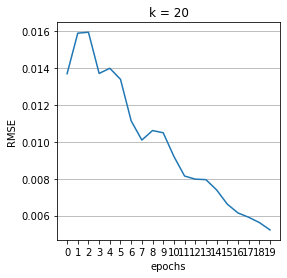

In [53]:
plt.figure(figsize=((4,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.title("k = 20")
plt.xlabel("epochs")
plt.ylabel("RMSE")
plt.grid(axis="y")

In [55]:
x = [x for x, y in train_mse]
y = [y for x, y in train_mse]

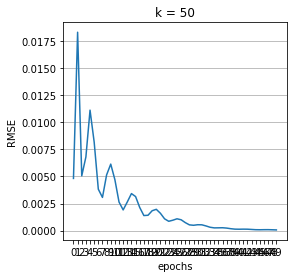

In [56]:
plt.figure(figsize=((4,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.title("k = 50")
plt.xlabel("epochs")
plt.ylabel("RMSE")
plt.grid(axis="y")

In [58]:
x = [x for x, y in train_mse]
y = [y for x, y in train_mse]

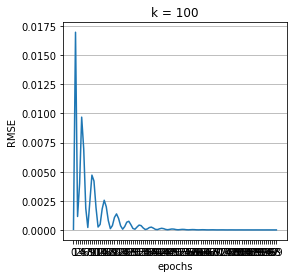

In [59]:
plt.figure(figsize=((4,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.title("k = 100")
plt.xlabel("epochs")
plt.ylabel("RMSE")
plt.grid(axis="y")

In [61]:
data['lessonId'] = le.fit_transform(data['lessonId'])

C:\Users\aloag\AppData\Local\Temp\ipykernel_7380\2326246968.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['lessonId'] = le.fit_transform(data['lessonId'])


In [62]:
user = torch.tensor([5])
lesson = torch.tensor(data['lessonId'].unique().tolist())
predictions = model(user, lesson).tolist()
print(predictions)

[1.4260730743408203, 0.6557088494300842, 0.3349047303199768, 1.7407866716384888, 0.7988539934158325, 0.452319860458374, 0.23950691521167755, 1.6200511455535889, 1.4017319679260254, 1.22890305519104, 0.13641631603240967, 0.11755409836769104, 0.1293712556362152, 0.10907803475856781, 0.6520931720733643, 0.5395483374595642, 0.9458184242248535, 0.463523805141449, 0.31200820207595825, 0.4298784136772156, 0.3666953146457672, 0.3317757844924927, 0.3496347963809967, 1.4551076889038086, 0.09981723874807358, 0.12466730922460556, 0.2328316569328308, 0.25572219491004944, 1.291282296180725, 0.3996580243110657, 0.735535204410553, 1.1575983762741089, 1.0738930702209473, 1.6398876905441284, 0.12340165674686432, 0.11592661589384079, 0.6254816055297852, 0.07589372247457504, 0.10370491445064545, 1.0852258205413818, 0.4989974796772003, 0.4984988272190094, 0.4684787392616272, 0.3534090518951416, 0.439414918422699, 0.45478034019470215, 0.48049065470695496, 0.48851361870765686, 0.5064153075218201, 0.246293589

In [63]:
predictions = np.array(predictions, dtype=np.float32)
sortedIndices = predictions.argsort()
sortedIndices

array([ 248,  243, 1135, ...,  294,  116,  102], dtype=int64)

In [163]:
sortedIndices = predictions.argsort()
recommended_lesson = data['lessonId'].unique()[sortedIndices][-10:][::-1]  # taking top 10
print(recommended_lesson)

[ 954    0 1010   13  104  745  882  964    1  977]


In [166]:
le.inverse_transform(recommended_lesson)

array(['6012d826cfe09249249f8fda', '6012bdcecfe09249249f7e9c',
       '6155603051b0d20016586147', '6012bdd4cfe09249249f7eba',
       '6012c2c9cfe09249249f7fee', '6012cbd6cfe09249249f86a8',
       '6012ccf1cfe09249249f881a', '611a4fe8aaba0c0016e02a4b',
       '6012bdcecfe09249249f7e9e', '611a6283aaba0c0016e02b65'],
      dtype=object)

In [72]:
recommended_lesson[0]

'6012d826cfe09249249f8fda'

In [73]:
data['lessonId']

958

In [162]:
lesson_data= data[['lessonId']]

In [165]:
recommendedlessons = lesson_data[lesson_data.lessonId.isin(recommended_lesson)]
recommendedlessons = recommendedlessons.reset_index(drop=True)
top10= recommendedlessons.rename(columns={'index':'top 10'})
top10['lessonId'].unique()

array([ 977,  964,  954,    0, 1010,    1,  882,  745,  104,   13])

## hybrid model

In [ ]:
# hyperparameter tuning
# emedding size

In [147]:
class NeuralNet(nn.Module):
    def __init__(self, num_users, num_lessons, emb_size=35, n_hidden=15,n_features=45):
        super(NeuralNet, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.lesson_emb = nn.Embedding(num_lessons, emb_size)
        self.layer1 = nn.Linear(emb_size*2 + n_features, n_hidden)
        self.layer2 = nn.Linear(n_hidden, 1)
        self.drop1 = nn.Dropout(0.1)
        
    def forward(self, u, v):
        user = self.user_emb(u)
        lessons = self.lesson_emb(v[:,1])
        features = v[:,3:]
        x = F.relu(torch.cat([user, lessons,features], dim=1))
        x = self.drop1(x)
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        return x

In [148]:
def train_epocs_hybrid(model, epochs=10, lr=0.01, wd=0.0, unsqueeze=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    model.train()
    for i in range(epochs):
        users = torch.LongTensor(train_df.userId.values) # .cuda()
        lessons = torch.LongTensor(train_df.values) #.cuda()
        views = torch.FloatTensor(train_df.views.values) #.cuda()
        if unsqueeze:
            views = views.unsqueeze(1)
        y_hat = model(users, lessons)
        loss = F.mse_loss(y_hat, views)
        train_mse_hybrid.append((i, loss.item()))
        if (i+1) % 10 == 0:
            print("Iteration: %d ; error = %.4f" % (i+1, loss.item()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    test_loss_hybrid(model, unsqueeze)

In [149]:
def test_loss_hybrid(model, unsqueeze=False):
    model.eval()
    users = torch.LongTensor(validation_df.userId.values) #.cuda()
    lessons = torch.LongTensor(validation_df.values) #.cuda()
    views = torch.FloatTensor(validation_df.views.values) #.cuda()
    if unsqueeze:
        views = views.unsqueeze(1)
    y_hat = model(users, lessons)
    loss = F.mse_loss(y_hat, views)
    print("test loss %.3f " % loss.item())

In [97]:
data['userId'] = le.fit_transform(data['userId'])
data['lessonId'] = le.fit_transform(data['lessonId'])

In [99]:
train_df,validation_df = train_test_split(data,test_size=0.2)

In [100]:
num_users = len(train_df.userId)
num_lessons = len(train_df)
print(num_users, num_lessons) 

3920 3920


In [150]:
model = NeuralNet(num_users, num_lessons, emb_size=35)
model

NeuralNet(
  (user_emb): Embedding(3920, 35)
  (lesson_emb): Embedding(3920, 35)
  (layer1): Linear(in_features=115, out_features=15, bias=True)
  (layer2): Linear(in_features=15, out_features=1, bias=True)
  (drop1): Dropout(p=0.1, inplace=False)
)

In [151]:
train_mse_hybrid=[]
train_epocs_hybrid(model,unsqueeze=True)

Iteration: 10 ; error = 324.0981
test loss 276.448 


In [152]:
x = [x for x, y in train_mse_hybrid]
y = [y for x, y in train_mse_hybrid]

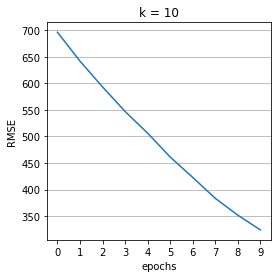

In [153]:
plt.figure(figsize=((4,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.title("k = 10")
plt.xlabel("epochs")
plt.ylabel("RMSE")
plt.grid(axis="y")

In [155]:
train_mse_hybrid=[]
train_epocs_hybrid(model,epochs = 100,unsqueeze=True)

Iteration: 10 ; error = 167.0545
Iteration: 20 ; error = 124.7939
Iteration: 30 ; error = 72.5527
Iteration: 40 ; error = 73.7700
Iteration: 50 ; error = 48.6317
Iteration: 60 ; error = 49.5932
Iteration: 70 ; error = 44.0341
Iteration: 80 ; error = 27.2118
Iteration: 90 ; error = 29.8484
Iteration: 100 ; error = 19.2198
test loss 14.380 


In [156]:
def plot_loss(train_mse_hybrid,title):
    x = [x for x, y in train_mse_hybrid]
    y = [y for x, y in train_mse_hybrid]
    plt.figure(figsize=((4,4)))
    plt.plot(x, y)
    plt.xticks(x, x)
    plt.title(title)
    plt.xlabel("epochs")
    plt.ylabel("RMSE")
    plt.grid(axis="y")

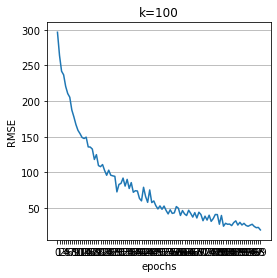

In [157]:
plot_loss(train_mse_hybrid,"k=100")

In [158]:
train_mse_hybrid=[]
train_epocs_hybrid(model,epochs = 200,unsqueeze=True)

Iteration: 10 ; error = 18.9886
Iteration: 20 ; error = 12.1607
Iteration: 30 ; error = 12.3673
Iteration: 40 ; error = 9.2038
Iteration: 50 ; error = 7.6395
Iteration: 60 ; error = 7.4034
Iteration: 70 ; error = 7.1088
Iteration: 80 ; error = 5.4667
Iteration: 90 ; error = 5.5133
Iteration: 100 ; error = 5.0023
Iteration: 110 ; error = 5.3008
Iteration: 120 ; error = 4.2764
Iteration: 130 ; error = 5.0927
Iteration: 140 ; error = 3.4334
Iteration: 150 ; error = 3.8940
Iteration: 160 ; error = 3.1032
Iteration: 170 ; error = 3.2044
Iteration: 180 ; error = 3.4670
Iteration: 190 ; error = 2.8907
Iteration: 200 ; error = 2.7054
test loss 18.257 


In [159]:
train_mse_hybrid=[]
train_epocs_hybrid(model,epochs = 300,unsqueeze=True)

Iteration: 10 ; error = 2.6690
Iteration: 20 ; error = 2.5157
Iteration: 30 ; error = 2.5228
Iteration: 40 ; error = 2.6621
Iteration: 50 ; error = 2.2768
Iteration: 60 ; error = 2.2018
Iteration: 70 ; error = 2.1639
Iteration: 80 ; error = 1.9935
Iteration: 90 ; error = 2.1566
Iteration: 100 ; error = 2.0293
Iteration: 110 ; error = 2.0192
Iteration: 120 ; error = 1.9501
Iteration: 130 ; error = 1.5531
Iteration: 140 ; error = 1.4212
Iteration: 150 ; error = 1.6364
Iteration: 160 ; error = 1.4423
Iteration: 170 ; error = 1.4982
Iteration: 180 ; error = 1.3904
Iteration: 190 ; error = 1.1571
Iteration: 200 ; error = 1.2560
Iteration: 210 ; error = 1.1257
Iteration: 220 ; error = 1.1204
Iteration: 230 ; error = 1.2553
Iteration: 240 ; error = 0.9709
Iteration: 250 ; error = 0.9274
Iteration: 260 ; error = 0.9413
Iteration: 270 ; error = 1.4056
Iteration: 280 ; error = 1.0363
Iteration: 290 ; error = 1.1523
Iteration: 300 ; error = 0.6528
test loss 15.968 


In [160]:
train_mse_hybrid=[]
train_epocs_hybrid(model,epochs = 400,unsqueeze=True)

Iteration: 10 ; error = 2.4818
Iteration: 20 ; error = 0.9671
Iteration: 30 ; error = 1.0271
Iteration: 40 ; error = 1.0010
Iteration: 50 ; error = 0.8041
Iteration: 60 ; error = 0.7457
Iteration: 70 ; error = 0.8286
Iteration: 80 ; error = 0.7043
Iteration: 90 ; error = 0.9807
Iteration: 100 ; error = 0.8545
Iteration: 110 ; error = 0.7584
Iteration: 120 ; error = 0.7585
Iteration: 130 ; error = 0.6789
Iteration: 140 ; error = 0.9045
Iteration: 150 ; error = 0.6486
Iteration: 160 ; error = 0.7710
Iteration: 170 ; error = 0.8567
Iteration: 180 ; error = 0.7175
Iteration: 190 ; error = 0.6112
Iteration: 200 ; error = 0.7399
Iteration: 210 ; error = 0.6186
Iteration: 220 ; error = 0.5872
Iteration: 230 ; error = 0.8299
Iteration: 240 ; error = 0.7265
Iteration: 250 ; error = 0.5093
Iteration: 260 ; error = 0.6117
Iteration: 270 ; error = 0.7210
Iteration: 280 ; error = 0.6360
Iteration: 290 ; error = 0.8660
Iteration: 300 ; error = 0.6905
Iteration: 310 ; error = 0.6398
Iteration: 320 ; 

In [161]:
train_mse_hybrid=[]
train_epocs_hybrid(model,epochs = 500,unsqueeze=True)

Iteration: 10 ; error = 2.3201
Iteration: 20 ; error = 0.8110
Iteration: 30 ; error = 0.9026
Iteration: 40 ; error = 0.6436
Iteration: 50 ; error = 0.5308
Iteration: 60 ; error = 0.4055
Iteration: 70 ; error = 1.0266
Iteration: 80 ; error = 0.4161
Iteration: 90 ; error = 0.6675
Iteration: 100 ; error = 0.5305
Iteration: 110 ; error = 0.6435
Iteration: 120 ; error = 0.6380
Iteration: 130 ; error = 0.5409
Iteration: 140 ; error = 0.5402
Iteration: 150 ; error = 0.4741
Iteration: 160 ; error = 0.8099
Iteration: 170 ; error = 0.6024
Iteration: 180 ; error = 0.6015
Iteration: 190 ; error = 0.5859
Iteration: 200 ; error = 0.9304
Iteration: 210 ; error = 0.5159
Iteration: 220 ; error = 0.4514
Iteration: 230 ; error = 0.5673
Iteration: 240 ; error = 0.5000
Iteration: 250 ; error = 0.4802
Iteration: 260 ; error = 0.5529
Iteration: 270 ; error = 0.4961
Iteration: 280 ; error = 0.5930
Iteration: 290 ; error = 0.5414
Iteration: 300 ; error = 0.5274
Iteration: 310 ; error = 0.6850
Iteration: 320 ; 

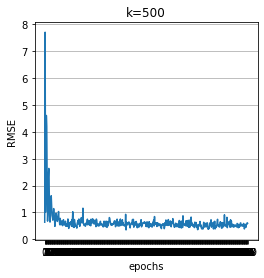

In [170]:
plot_loss(train_mse_hybrid,"k=500")

In [168]:
data

,userId,lessonId,views,student_view_count,questions_count,numberOfCorrectAnswers,numberOfWrongAnswers,numberOfSkippedQuestions,score,count_new,...,subject_Further Mathematics,subject_Home Economics,subject_Literature in English,subject_Mathematics,subject_Module 1 HTML for Beginners,subject_Module 2 CSS for Beginners,subject_Module 3 Javascript for Beginners,subject_Physics,subject_Social Studies,subject_Yoruba
0,757,958,73.0,80.0,0.0,0.000000,0.000000,0.000000,0.0,5,...,0,0,0,0,0,0,0,0,0,1
1,756,970,3.0,6.0,0.0,0.000000,0.000000,0.000000,0.0,4,...,0,0,0,0,0,0,0,0,0,1
2,756,968,6.0,7.0,0.0,0.000000,0.000000,0.000000,0.0,5,...,0,0,0,0,0,0,0,0,0,1
3,756,959,23.0,27.0,0.0,0.000000,0.000000,0.000000,0.0,10,...,0,0,0,0,0,0,0,0,0,1
4,755,958,73.0,80.0,0.0,0.000000,0.000000,0.000000,0.0,9,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4895,24,1,23.0,27.0,2.0,1.333333,1.666667,0.666667,34.0,12,...,0,0,0,0,0,0,0,0,0,0
4896,24,0,62.0,184.0,4.0,2.200000,1.800000,0.000000,55.0,103,...,0,0,0,0,0,0,0,0,0,0
4897,24,0,62.0,184.0,4.0,2.200000,1.800000,0.000000,55.0,103,...,0,0,0,0,0,0,0,0,0,0
4898,24,1,23.0,27.0,2.0,1.333333,1.666667,0.666667,34.0,12,...,0,0,0,0,0,0,0,0,0,0


In [169]:
user_for_recommendation = data[data.userId == 5].to_numpy()

In [172]:
recommendation_values= model(torch.LongTensor(user_for_recommendation[:,0]),torch.LongTensor(user_for_recommendation)).detach().numpy().reshape(-1)
recommendation_values

array([12.300441 ,  1.1310482, 20.134256 , 20.164932 ], dtype=float32)

In [173]:
np.argsort(recommendation_values)[-10:][::-1]

array([3, 2, 0, 1], dtype=int64)